In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

from pclib.nn.models import FCClassifierSSLI
from pclib.nn.layers import FCPW
from pclib.optim.train import train
from pclib.utils.plot import plot_stats
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y, reTanh
from pclib.utils.customdataset import PreloadedDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:

class TanhTransform(object):
    def __init__(self, a=1., b=0., c=1.0):
        self.a = a
        self.b = b
        self.c = c

    def __call__(self, img):
        return ((img * self.a).tanh() + self.b) * self.c

class InvTanhTransform(object):
    def __call__(self, img):
        num = 1 + img
        div = (1 - img).clamp(min=1e-6)
        m = 0.5 * torch.log(num / div)
        return m

class SigmoidTransform(object):
    def __call__(self, img):
        return img.sigmoid()
    
class ReLUTanhTransform(object):
    def __call__(self, img):
        return F.relu(img.tanh())

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # InvTanhTransform(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(a=2.0),
    # TanhTransform(a=1.0, b=1.0, c=0.5),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# # shorten dataset
# length = 1000
# dataset = torch.utils.data.Subset(dataset, range(length))

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

  0%|          | 0/48000 [00:00<?, ?it/s]

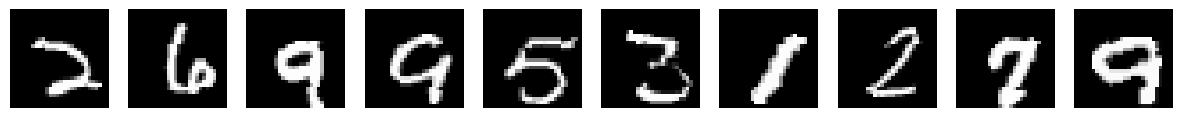

Max value:  tensor(2.8215, device='cuda:0')
Min value:  tensor(-0.4242, device='cuda:0')


In [4]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [9]:
seed = 42
torch.manual_seed(seed)

model = FCClassifierSSLI(
    input_size=INPUT_SHAPE, 
    num_classes=NUM_CLASSES, 
    hidden_sizes=[600, 200, 200],
    bias=True, 
    symmetric=True,
    precision_weighted=False,
    actv_fn=reTanh,
    steps=100,
    gamma=0.34,
    beta=1.0,
    ).to(device)
step = 0
stats = None

layer 1: abs_mean: 0.0017, mean: 0.0017, std: 0.0408, max: 1.0000, min: -0.0000
layer 2: abs_mean: 0.0050, mean: 0.0050, std: 0.0705, max: 1.0000, min: -0.0000
layer 3: abs_mean: 0.0050, mean: 0.0050, std: 0.0705, max: 1.0000, min: -0.0000


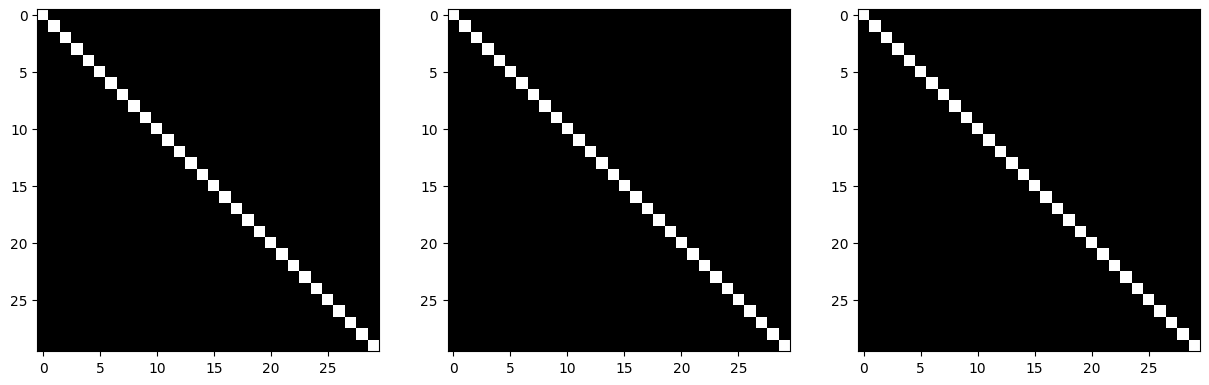

In [10]:
plt.figure(figsize=(15, 5))
for i, layer in enumerate(model.layers):
    if i == 0:
        continue
    # mat = layer.weight_lat
    mat = layer.weight_lat * layer.lat_conn_mat
    # mat = layer.weight_lat - layer.weight_lat.diag().diag()
    # mat = layer.weight_lat - torch.eye(layer.weight_lat.shape[0]).to(device)
    abs_mean = mat.abs().mean().item()
    mean = mat.mean().item()
    std = mat.std().item()
    maxi = mat.max().item()
    mini = mat.min().item()
    print(f"layer {i}: abs_mean: {abs_mean:.4f}, mean: {mean:.4f}, std: {std:.4f}, max: {maxi:.4f}, min: {mini:.4f}")
    # show mat graphically
    plt.subplot(1, 3, i)
    plt.imshow(mat[:30,:30].detach().cpu(), cmap='gray')
plt.show()

torch.Size([600, 600])
layer 1: abs_mean: 0.0017, mean: 0.0017, std: 0.0408, max: 1.0000, min: -0.0000
torch.Size([200, 200])
layer 2: abs_mean: 0.0050, mean: 0.0050, std: 0.0705, max: 1.0000, min: -0.0000
torch.Size([200, 200])
layer 3: abs_mean: 0.0050, mean: 0.0050, std: 0.0705, max: 1.0000, min: -0.0000


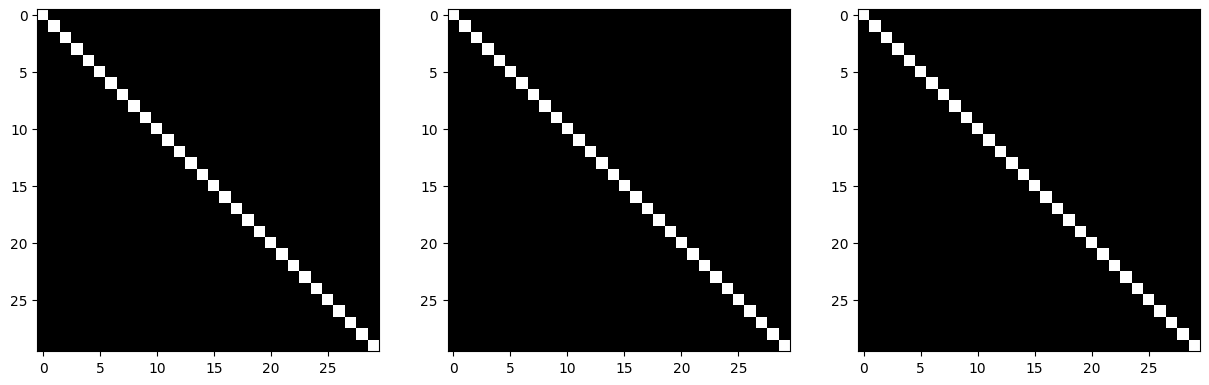

In [11]:
plt.figure(figsize=(15, 5))
for i, layer in enumerate(model.layers):
    if i == 0:
        continue
    # mat = layer.weight_lat
    mat = layer.weight_lat * layer.lat_conn_mat
    # mat = layer.weight_lat - layer.weight_lat.diag().diag()
    # mat = layer.weight_lat - torch.eye(layer.weight_lat.shape[0]).to(device)
    print(mat.shape)
    abs_mean = mat.abs().mean().item()
    mean = mat.mean().item()
    std = mat.std().item()
    maxi = mat.max().item()
    mini = mat.min().item()
    print(f"layer {i}: abs_mean: {abs_mean:.4f}, mean: {mean:.4f}, std: {std:.4f}, max: {maxi:.4f}, min: {mini:.4f}")
    # show mat graphically
    plt.subplot(1, 3, i)
    plt.imshow(mat[:30,:30].detach().cpu(), cmap='gray')

plt.show()


In [12]:
# Train Loop
NUM_EPOCHS = 30
BATCH_SIZE = 1000

step, stats = train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    lr=0.001, 
    c_lr=0.0,
    batch_size=BATCH_SIZE,
    reg_coeff=1.0,
    step=step, 
    stats=stats,
    optim='AdamW',
    # grad_mode='manual',
)
LEARNING_RATE = 0.0
NUM_EPOCHS = 10
step, stats = train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    lr=0.0,
    c_lr=0.01,
    batch_size=BATCH_SIZE,
    reg_coeff=0.02,
    step=step, 
    stats=stats,
    optim='AdamW',
)

plot_stats(stats, model)

KeyboardInterrupt: 

layer 1 5 largest values:  [[0.7122844457626343, 0.6480820775032043, 0.6249468326568604, 0.530404806137085, 0.4805261194705963], [0.6954469680786133, 0.6919915676116943, 0.6854541301727295, 0.6458198428153992, 0.6417177319526672], [0.727741003036499, 0.6180891990661621, 0.5869635343551636, 0.3871014416217804, 0.25920039415359497], [0.5729011297225952, 0.5614019632339478, 0.5411901473999023, 0.5101564526557922, 0.5088068246841431], [0.4077099561691284, 0.2839946746826172, 0.20344051718711853, 0.16978204250335693, 0.15113967657089233], [0.7388337850570679, 0.7095426321029663, 0.6902478933334351, 0.6245996952056885, 0.3568309545516968], [0.6576893329620361, 0.6441725492477417, 0.604934811592102, 0.6018632650375366, 0.4979155659675598], [0.6471583843231201, 0.5404073596000671, 0.4537467956542969, 0.3850887417793274, 0.3381165862083435], [0.5927552580833435, 0.5887117385864258, 0.5710772275924683, 0.5683398842811584, 0.5501723885536194], [0.703779935836792, 0.699086606502533, 0.630617976188

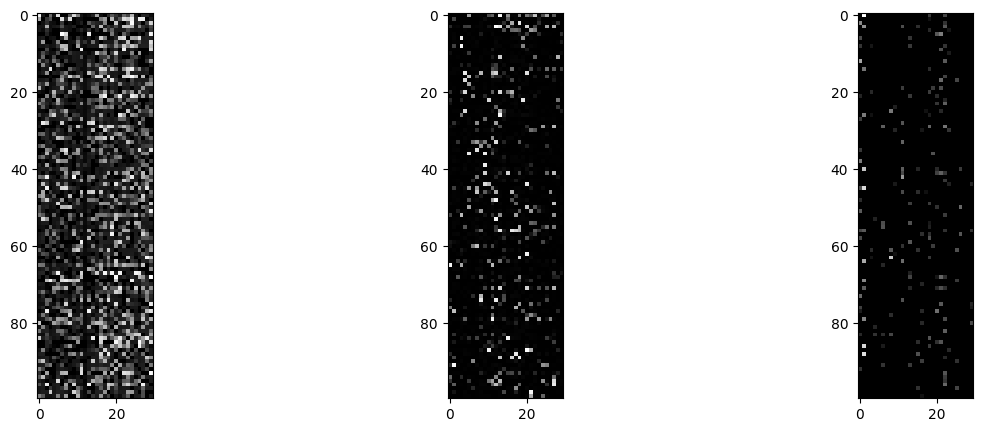

In [9]:
# Check Winner takes all
# is there an SDR?

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_x = next(iter(train_loader))[0].flatten(1)
val_x = next(iter(val_loader))[0].flatten(1)
train_out, train_state = model(train_x, steps=1000)
val_out, val_state = model(val_x)

plt.figure(figsize=(15, 5))
for i, layer in enumerate(model.layers):
    if i == 0:
        continue
    vals = layer.actv_fn(train_state[i]['x'][:100,:30])
    print(f"layer {i} 5 largest values: ", vals.topk(5, dim=1)[0].squeeze().tolist())
    plt.subplot(1, 3, i)
    plt.imshow(vals.detach().cpu(), cmap='gray')


In [10]:
plt.plot(stats['train_corr'])

KeyError: 'train_corr'

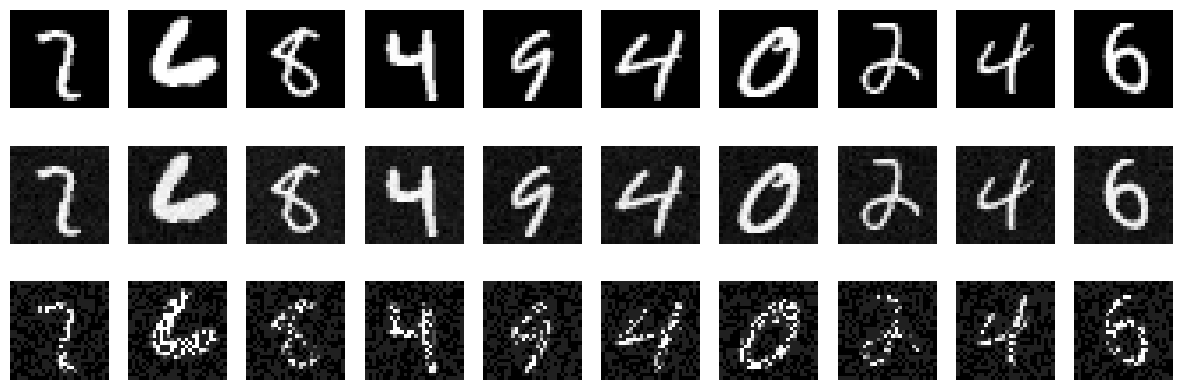

In [10]:
# get 10 images
images = []
noisy_images = []
partial_images = []
labels = []
for i in range(10):
    img, _ = val_dataset[i]
    images.append(img)
    noisy_images.append(img + torch.randn_like(img) * 0.1)
    partial_images.append(img * (torch.rand_like(img) < 0.5))
    labels.append(label)

# show images
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i, ax in enumerate(axes[0]):
    ax.imshow(images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    ax.imshow(noisy_images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[2]):
    ax.imshow(partial_images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

images = torch.stack(images).flatten(1)
noisy_images = torch.stack(noisy_images).flatten(1)
partial_images = torch.stack(partial_images).flatten(1)

torch.Size([10, 784])


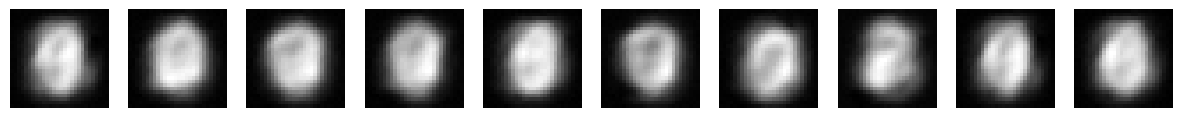

In [11]:
# reconstruct noisy images
out, state = model.reconstruct(noisy_images)
print(out.shape)


# show reconstructed images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(out[i].cpu().reshape(28, 28), cmap='gray')
    ax.axis('off')

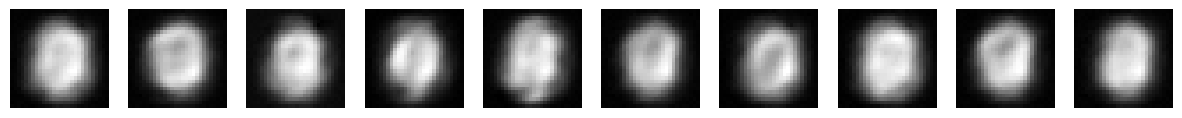

In [12]:
# reconstruct partial images
out, state = model.reconstruct(partial_images)

# show reconstructed images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(out[i].cpu().reshape(28, 28), cmap='gray')
    ax.axis('off')

In [13]:
targets = torch.arange(NUM_CLASSES).to(device)
images = model.generate(targets)

fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = images[i]
    ax.imshow(img.detach().squeeze().cpu().view(28,28), cmap='gray')
    ax.axis('off')

NotImplementedError: 

0.09983333333333333


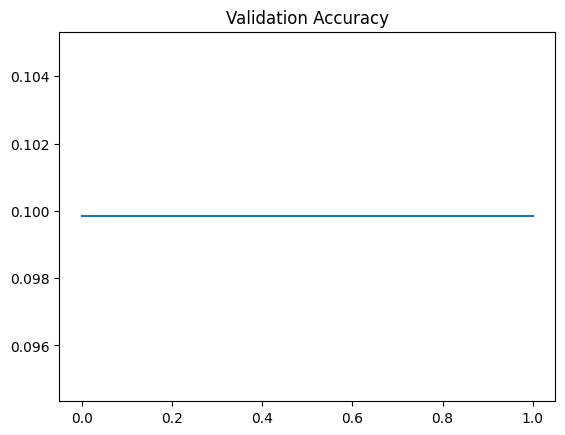

In [14]:
print(max(stats['val_acc']))
plt.plot(stats['val_acc'])
plt.title("Validation Accuracy")
plt.show()

In [15]:
for i, layer in enumerate(model.layers[1:]):
    if layer.weight_td is not None:
        print(layer.weight_lat.abs().mean(), layer.weight_td.abs().mean())
    else:
        print(layer.weight_lat.abs().mean())

tensor(0.0996, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0193, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0902, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0114, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0478, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0112, device='cuda:0', grad_fn=<MeanBackward0>)


In [16]:
max(stats['val_acc'])

0.09983333333333333

In [17]:
# Current Accuracy and Error Rate
acc = accuracy(model, val_dataset, steps=0)
error = 100 * (1 - acc)
print(f'Current Val Acc: {acc} | error_rate: {error:0.2f} %')

Current Val Acc: 0.07566666666666666 | error_rate: 92.43 %


In [ ]:
# # Shows statistics over multiple models. models = [model1, model2, ...]


# train_vfes = torch.tensor([stats[i]['train_vfe'][-1] for i in range(num_models)])
# val_vfes = torch.tensor([stats[i]['val_vfe'][-1] for i in range(num_models)])
# val_accs = torch.tensor([stats[i]['val_acc'][-1] for i in range(num_models)])

# # Show statistics across models, std is nan if num_models = 1
# print(f"Tra VFE - mean: {train_vfes.mean():.3f} | std: {train_vfes.std():.3f} | min: {train_vfes.min():.3f} | max: {train_vfes.max():.3f}")
# print(f"Val VFE - mean: {val_vfes.mean():.3f} | std: {val_vfes.std():.3f} | min: {val_vfes.min():.3f} | max: {val_vfes.max():.3f}")
# print(f"Val Acc - mean: {val_accs.mean():.3f} | std: {val_accs.std():.3f} | min: {val_accs.min():.3f} | max: {val_accs.max():.3f}")

NameError: name 'num_models' is not defined

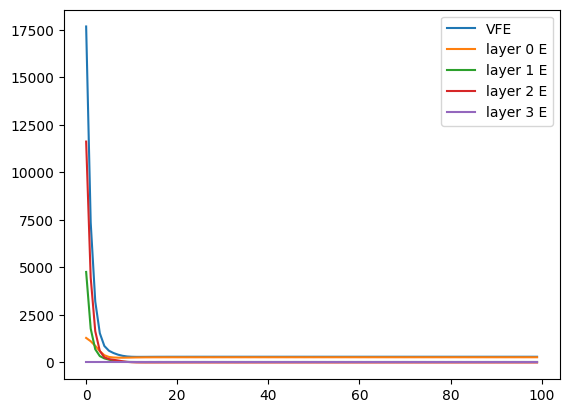

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


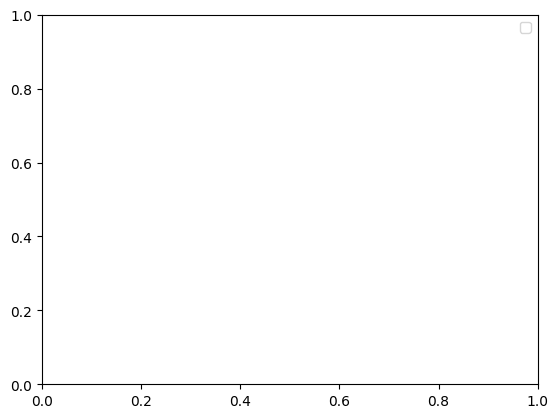

In [18]:
from pclib.utils.functional import format_y
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
images, y = next(iter(train_loader))
x = images.view(images.shape[0], -1)
y = format_y(y, 10)
vfes, X, E = track_vfe(model, x, steps=100, plot_Es=True)

In [19]:
assert isinstance(model.layers[0], PrecisionWeighted), "This cell only works for PrecisionWeighted layers"
# show diag of weight_var matrix as 28x28 image for layer 0
model = model
layer = 0
weight_var = model.layers[0].weight_var.detach().cpu().numpy()
# weight_var = model.layers[-1].weight_var.diag().reshape(28,28).detach().cpu().numpy()
plt.imshow(weight_var, cmap='gray')
plt.colorbar()
plt.show()
weight_var.min(), weight_var.max()


NameError: name 'PrecisionWeighted' is not defined